intéressant: https://www.scitepress.org/Papers/2018/67520/67520.pdf

mini resnet à la catégorie transfer learning: https://www.tensorflow.org/guide/keras/functional

# I. Librairies

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm_n
import time
import sys

In [2]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.0.0
Num GPUs Available: 1


In [3]:
from generalBDDHandler import GeneralBDDHandler
from generalIOLib import FlatInputDic, GeneralOutputLib
from datasets.BatchGenerator import BatchGenerator

100%|███████████████████████████████████████████████████████████████████████| 102510/102510 [00:04<00:00, 23155.54it/s]


In [4]:
random_seed = 42

## II Batch Generator

In [5]:
loading_batch_size = 20000
test_split = 0.2
validation_split = 0.2
batch_generator = BatchGenerator("datasets/generalIO_v2.csv", loading_batch_size, validation_split, test_split, random_seed )

lines offset reading: 21722295it [03:19, 109025.77it/s]


# III Model

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten, Conv2D, Activation, MaxPooling2D,GlobalAveragePooling2D, BatchNormalization,concatenate
from tensorflow.keras.optimizers import Adam

In [7]:
flatInputLib = FlatInputDic()
generalOutputLib = GeneralOutputLib()
def create_MLP_CNN():
    
    mlp_inputs = Input(shape = (7,), name = 'mlp')
    cnn_inputs = Input(shape = (29,15,7), name = 'cnn')
    
    #mlp model
    mlp_core = Dense(16, activation = 'relu')(mlp_inputs)
    mlp_core = Dense(16, activation = 'relu')(mlp_core)
    
    #cnn model
    cnn_core = Conv2D(128, (3, 3), activation='relu', padding = 'same')(cnn_inputs)
    cnn_core = Conv2D(128, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = MaxPooling2D((2, 2))(cnn_core)
    cnn_core = Conv2D(256, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = Conv2D(256, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = MaxPooling2D((2, 2))(cnn_core)
    cnn_core = Conv2D(512, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = Conv2D(512, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = GlobalAveragePooling2D()(cnn_core)
    
    #assembly
    x = concatenate([mlp_core, cnn_core])
    
    #dense end
    x = Dropout(0.2)(x)
    x = Dense(generalOutputLib.index, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(generalOutputLib.index, activation = 'softmax')(x)
    
    
    #model
    model = Model(inputs = [mlp_inputs, cnn_inputs], outputs = [output])
    
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn (InputLayer)                [(None, 29, 15, 7)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 29, 15, 128)  8192        cnn[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 29, 15, 128)  147584      conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 7, 128)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

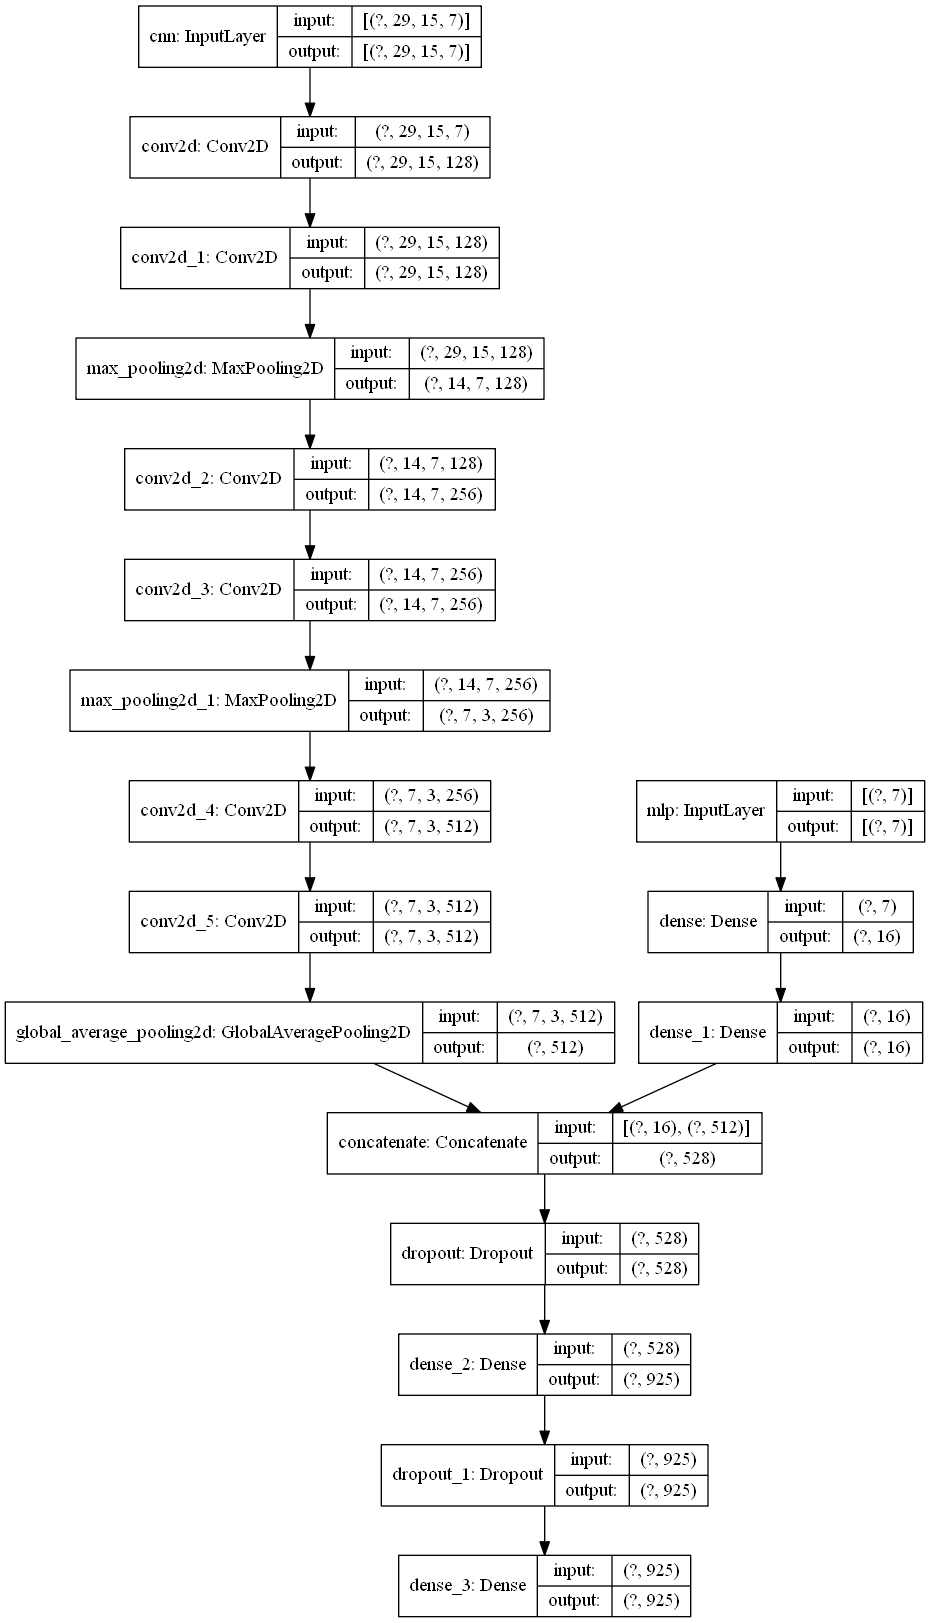

In [8]:
model = create_MLP_CNN()
print(model.summary())
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [9]:
optimizer = Adam() #tf.optimizers.SGD(learning_rate = 1e-3)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')

In [10]:
# define metrics
mean_loss = tf.keras.metrics.Mean(name='train_loss')
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy() 

In [11]:
# define training and evaluation steps
def batchIterator(features, batch_size):
    features_size = features[1].shape[0]
    begin_index = 0
    end_index = 0
    while(end_index != features_size):
        end_index = min(begin_index + batch_size, features_size)
        yield ((features[0][0][begin_index:end_index], features[0][1][begin_index:end_index]), features[1][begin_index:end_index])
        begin_index = end_index


@tf.function
def forward(features, training=False):
    predictions = model.call(features[0], training=training)
    loss = tf.losses.categorical_crossentropy(
            y_true=features[1],
            y_pred=predictions)
    return loss, predictions

@tf.function
def train_step(features):
    with tf.GradientTape() as tape:
        loss, predictions = forward(features, training=True)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    _ = mean_loss.update_state(loss)
    _ = categorical_accuracy.update_state(features[1], predictions)
    accuracy = categorical_accuracy.result()
    return mean_loss.result(), accuracy

@tf.function
def evaluate(features):
    loss, predictions = forward(features)
    _ = mean_loss.update_state(loss)
    _ = categorical_accuracy.update_state(features[1], predictions)
    accuracy = categorical_accuracy.result()
    return mean_loss.result(), accuracy

## V Training

In [ ]:
n_training_samples = len(batch_generator.train_index)
n_epochs = 4
bar_position = 1
training_batch_size = 512
pbar1 = tqdm_n(desc="training model", total = n_epochs, position = 0)
for epoch_num in range(n_epochs):
    pbar2 = tqdm_n(desc = f"epoch {epoch_num} training setup ...", total = n_training_samples, position = bar_position)
    for features, infos in batch_generator.getTrainBatches2(loading_batch_size, n_workers = 3):
        for training_batch_features in batchIterator(features, training_batch_size):
            loss, accuracy = train_step(training_batch_features)
            pbar2.set_description(f"epoch {epoch_num}: train loss/acc: {loss:.3f}/{accuracy:2.2%}")
            pbar2.update(training_batch_features[1].shape[0])
    pbar2.close()
    bar_position += 1
    for i in range(3):
        features, infos = batch_generator.getRandomValidation(10000)
        loss, accuracy = evaluate(features)
        tqdm_n.write(f"validation loss/acc {loss:.3f}/{accuracy:2.2%}")
    pbar1.update(1)


validation loss/acc 0.731/81.24%
validation loss/acc 0.731/81.24%
validation loss/acc 0.731/81.24%


In [21]:
from tensorflow.keras.models import model_from_json
directory = "models"
model_name = "model_1_8110"
json_model = model.to_json()
with open(f"{directory}/{model_name}.json",'w') as json_file:
    json_file.write(json_model)
model.save_weights(f"{directory}/{model_name}.h5")